# Preprocessing data 

## 1. Preparations
### 1.1 Import required packages

In [14]:
# import rasterio
try:
    import rasterio
except:
    %pip install rasterio
    import rasterio

import rasterio.features
import rasterio.warp
from rasterio.windows import Window
from rasterio.features import geometry_mask
from rasterio.features import rasterize

In [6]:
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import json  # for saving patch metadata in JSON format

### 1.2 Set directories and file paths

In [7]:
# input directories
# raster data
gtif_dir = r"D:\Drohne\1_OHB\1_OHB_Normalbetrieb\3_OHB_Juli_2024\Outputs\RGB\GeoTIFF"
# class labels
shp_dir = r"G:\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\shapefiles"

# output directories for patches
# as GeoTIFFs
output_gtif_dir = r"D:\MoSE\preprocessing\gtif_outputs"
# as NumpyArrays
output_nparr_dir = r"D:\MoSE\preprocessing\nparr_outputs"
# for JSON metadata
output_json_dir = r"D:\MoSE\preprocessing\json_outputs"

## 2. Create Patches
### 2.1 Set Hyperparameters

In [8]:
# exact paths to files
# raster data
gtif_name = "A01"
gtif_path = gtif_dir + r"\OHB_Abschnitt_01.tif"
# class labels
shp_path = shp_dir + r"\GSK_24_WGS84.shp"

In [9]:
# parameters for patches
PATCH_SIZE = 512 # 512x512 pixel per patch
STRIDE = 256 # 256 pixel overlap between patches

### 2.2 Label preparations and Class Coding

In [10]:
labels = gpd.read_file(shp_path)
labels["Elementtyp"].unique()

array(['Einzelstein', 'Wurzelstock', 'Steinverbauung', 'Totholz',
       'Steinriegel', 'Schotterbank', 'Schlamm_Sandinsel',
       'Sand_Schlammbank', 'Schotterinsel', None], dtype=object)

In [12]:
# Remove labels without class 
labels_filtered = labels[labels["Elementtyp"].notnull()]
print(labels_filtered["Elementtyp"].unique())


# labels_filtered = labels_filtered[labels_filtered.geometry.notnull()]
# labels_filtered = labels_filtered[labels_filtered.geometry.is_valid]
# labels_filtered = labels_filtered[~labels_filtered.geometry.is_empty]
# labels_filtered = labels_filtered[labels_filtered.geometry.area > 0]
# print(labels_filtered["Elementtyp"].unique())
# print(labels_filtered)

['Einzelstein' 'Wurzelstock' 'Steinverbauung' 'Totholz' 'Steinriegel'
 'Schotterbank' 'Schlamm_Sandinsel' 'Sand_Schlammbank' 'Schotterinsel']


Class coding

In [16]:
label_codes = { # assign a unique pixel value to each class (element type)
    "Einzelstein": 1,
    "Wurzelstock": 2,
    "Steinverbauung": 3,
    "Totholz": 4,
    "Steinriegel": 5,
    "Schotterbank": 6,
    "Schlamm_Sandinsel": 7,
    "Sand_Schlammbank": 8,
    "Schotterinsel": 9
}

In [103]:
label_codes.items()

dict_items([('Einzelstein', 1), ('Wurzelstock', 2), ('Steinverbauung', 3), ('Totholz', 4), ('Steinriegel', 5), ('Schotterbank', 6), ('Schlamm_Sandinsel', 7), ('Sand_Schlammbank', 8), ('Schotterinsel', 9)])

In [104]:
# dictionary
label_codes["Totholz"]

4

In [105]:
# reversed dictionary
reversed_label_codes = {v: k for k, v in label_codes.items()} # v = value, k = key
reversed_label_codes[4]

'Totholz'

In [18]:
num_classes = len(label_codes)
num_classes

9

In [19]:
label_codes_path = os.path.join(output_json_dir, "label_codes.json")
with open(label_codes_path, "w") as json_file:
    json.dump(label_codes, json_file, indent=4)

### 2.3 Create the patch loop

In [87]:
#######################################################
# 1. Load the GeoTIFF (orthophoto)
with rasterio.open(gtif_path) as src:
    # nparr_data = src.read() # reads raster data of the GeoTIFF as NumPy-Array
    gtif_width, gtif_height = src.width, src.height
    gtif_transform = src.transform  # transformation matrix (whole image)
    gtif_crs = src.crs  # coordinate system
    gtif_meta = src.meta.copy() # original metadata like coordinate system, resolution, datatype
    gtif_bounds = src.bounds
    #######################################################

    # 2. Transform labels to crs of the orthophoto
    labels_crs = labels_filtered.to_crs(gtif_crs)

    #######################################################
    # 3. LOOP for patches
    #######################################################

    # set patch-id to zero
    patch_id = 0 # unique counter

    # Loop over the image in steps of STRIDE (overlapping patches if STRIDE < PATCH_SIZE)
    for y in range(0, gtif_height, STRIDE): # vertical movement y (start point: 0, end point: height, steps: STRIDE)
        for x in range(0, gtif_width, STRIDE): # horizontal movement x (start point: 0, end point: width, steps: STRIDE)
            
            # 3.1 Define window (patch)
            window = Window(x, y, PATCH_SIZE, PATCH_SIZE) 
            # defines a patch/window with origin (x, y) and a size of PATCH_SIZExPATCH_SIZE 

            # 3.2 Calculate the transformation matrix for this patch
            patch_transform = src.window_transform(window) 
            # this transformation matrix describes how the pixel coordinates of this window can be converted into 
            # the world coordinates of the image (geocoordinates)

            # 3.3 Extract raster data for the patch
            patch_data = src.read(window=window, indexes=[1, 2, 3]) # read only the first three bands (ignore the fourth band)
            # patch_data should be an array with shape [bands, PATCH_SIZE, PATCH_SIZE]
            
            # 3.4 Skip incomplete patches
            # if the calculated patch is partially outside the image boundaries (patch is smaller than PATCH_SIZE),
            # skip the patch to avoid errors
            if patch_data.shape[1] < PATCH_SIZE or patch_data.shape[2] < PATCH_SIZE:
                continue

            # 3.5 Check for "NoData" pixels in bands 0-2 (value = 255)
            nodata_value = 255  # Define the NoData value
            nodata_pixels = (patch_data == nodata_value).sum()  # Count NoData pixels across all bands
            total_pixels = PATCH_SIZE * PATCH_SIZE * patch_data.shape[0]  # Total pixels in the patch (3 bands)
            nodata_ratio = nodata_pixels / total_pixels # calculate the nodata-ratio
            # Skip patch if more than 50% of the pixels are NoData
            if nodata_ratio > 0.5:
                continue

            #######################################################
            # 4. Create masks for the labels
            #######################################################

            # 4.1 Calculate geographical coordinates (boundaries) of current patch 
            patch_bounds = rasterio.windows.bounds(window, gtif_transform) # with orthophoto transformation matrix 
            
            # 4.2 Filters label polygons which are inside the patch
            patch_labels = labels_crs.cx[ # labels_crs.cx (pandas) > filters geometries by coordinates
                patch_bounds[0]:patch_bounds[2],  # min_x:max_x
                patch_bounds[1]:patch_bounds[3],  # min_y:max_y
            ]
            

            
            # 4.3 Create binary masks with as many layers as classes
            # set mask to None
            mask = None

            if not patch_labels.empty: # if there are any labels in this patch 
                mask = np.zeros((num_classes, PATCH_SIZE, PATCH_SIZE), dtype=np.uint8) # initialize empty mask with 9 layers for the 9 classes
                
                # print("Labels in the patch:\n", patch_labels)
                # for every (row in) existing labels in this patch
                for _, row in patch_labels.iterrows():

                    class_name = row["Elementtyp"] # wich class has this label?
                    # print(class_name)

                    geom = row["geometry"] # wich geometry has this label?
                    # print(geom)
                              
                    class_idx = label_codes[class_name] - 1  # so in **wich layer/position in the mask** depending on the class
                                                             # should we write the geometry of this label
                    # print("layer", class_idx, "of the mask")

        
                    # fill mask with code values
                    mask[class_idx] = rasterize( # rasterize in layer "?" of the mask
                        [(geom, 1)],  # pixelvalue 1 for pixel inside the polygon
                        out_shape=(PATCH_SIZE, PATCH_SIZE), 
                        transform=patch_transform,
                        out=mask[class_idx],  # Vorhandene Maske erweitern
                        fill=0,  # background remains 0
                        merge_alg=rasterio.enums.MergeAlg.add
                    ).astype(np.uint8)

            #######################################################
            # 5. Save patch
            #######################################################
            
            # 5.1 Update meta data of the patch
            patch_meta = gtif_meta.copy()
            patch_meta.update({
                "height": PATCH_SIZE,
                "width": PATCH_SIZE,
                "transform": patch_transform,
                "count": 3,
                "blockxsize": 256, # block width
                "blockysize": 256, # block height
                "tiled": True, # tiling-activation
                "compress": "DEFLATE",  # Compression optimized for storage space
                "predictor": 2,    
                "dtype": "uint8",     
            })

            # 5.2 Save patch as GeoTIFF
            patch_path = os.path.join(output_gtif_dir, f"{gtif_name}_patch_{patch_id}.tif")
            with rasterio.open(patch_path, "w", **patch_meta) as dst:
                dst.write(patch_data)  # write orthophoto bands (3 bands) 

            # 5.3 Save mask as GeoTIFF
            if mask is not None:
                patch_mask_path = os.path.join(output_gtif_dir, f"{gtif_name}_patch_{patch_id}_mask.tif")
                with rasterio.open(
                    patch_mask_path,
                    "w",
                    driver="GTiff",
                    height=PATCH_SIZE,
                    width=PATCH_SIZE,
                    count=num_classes,  # Anzahl der Klassen entspricht der Anzahl der Bänder
                    dtype=np.uint8,
                    transform=patch_transform,
                ) as dst:
                    for i in range(num_classes):
                        dst.write(mask[i], i + 1)


            # 5.4 Save patch as NumpyArray
            npy_data = {"image": patch_data}
            np.save(os.path.join(output_nparr_dir, f"{gtif_name}_patch_{patch_id}.npy"), npy_data)

            # 5.5 Save mask as NumpyArray
            if mask is not None:
                np.save(os.path.join(output_nparr_dir, f"{gtif_name}_patch_{patch_id}_mask.npy"), mask)

            #######################################################
            # 6. Current status
            if patch_id % 100 == 0:
                print(f"{patch_id} patches created...")

            # 7. Loop for the next patch 
            patch_id += 1
            #######################################################
    
    #######################################################
    # 9. END MESSAGE
    print(f"{patch_id} patches have been created and saved as GeoTIFF in {output_gtif_dir} and as NumpyArray in {output_nparr_dir}. Metadata saved as JSON-file in {output_json_dir}")

0 patches created...
100 patches created...
200 patches created...
300 patches created...
400 patches created...


KeyboardInterrupt: 

### 2.4 OPTIONAL: Plot patches 
1. Plot the image data (orthophoto) of a patch saved as GeoTIFF

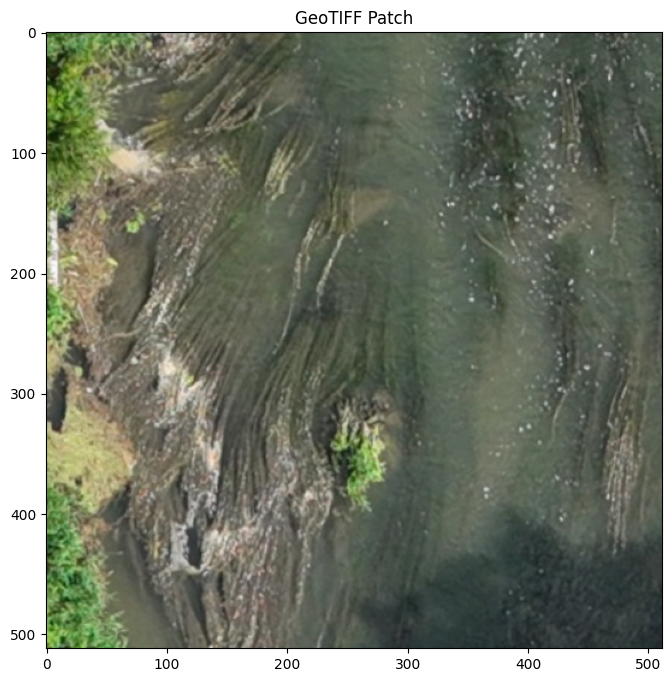

In [88]:
# Hyperparameter: Wich patch (id)?
# TEST_PATCH_ID = 1089
TEST_PATCH_ID = 184

# test GeoTIFF patch path
test_gtif = output_gtif_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}.tif"

# load test GeoTIFF patch and plot the image data (RGB = first three bands)
with rasterio.open(test_gtif) as src:
    patch_image_data = src.read([1, 2, 3])
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(patch_image_data.transpose(1, 2, 0))  # transpose for RGB
    ax.set_title("GeoTIFF Patch")
    plt.show()

2. Plot the image data of a patch saved as NumpyArray

In [89]:
# test NumpyArray patch path
test_patch_nparr = output_nparr_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}.npy"

# load NumpyArray (dtype = object > saved as dictionary)
patch_data_npy = np.load(test_patch_nparr, allow_pickle=True)

In [90]:
# Load the image data of the NumpyArray
test_image_data_npy = patch_data_npy.item().get("image") # key "image"
# test_image_data_npy

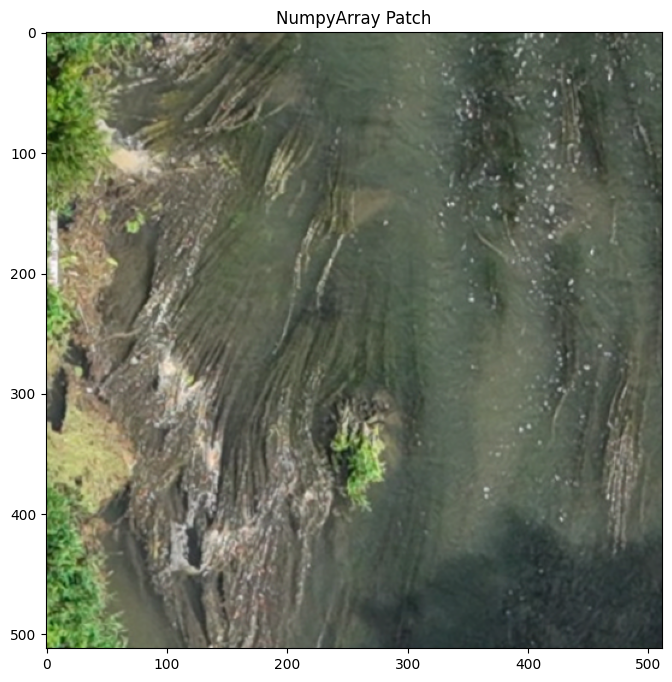

In [91]:
# plot the image data
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(test_image_data_npy.transpose(1, 2, 0))  # transpose for RGB depiction
ax.set_title("NumpyArray Patch")
plt.show()

3. Plot NumpyArray masks (if existent) 

In [96]:
label_codes

{'Einzelstein': 1,
 'Wurzelstock': 2,
 'Steinverbauung': 3,
 'Totholz': 4,
 'Steinriegel': 5,
 'Schotterbank': 6,
 'Schlamm_Sandinsel': 7,
 'Sand_Schlammbank': 8,
 'Schotterinsel': 9}

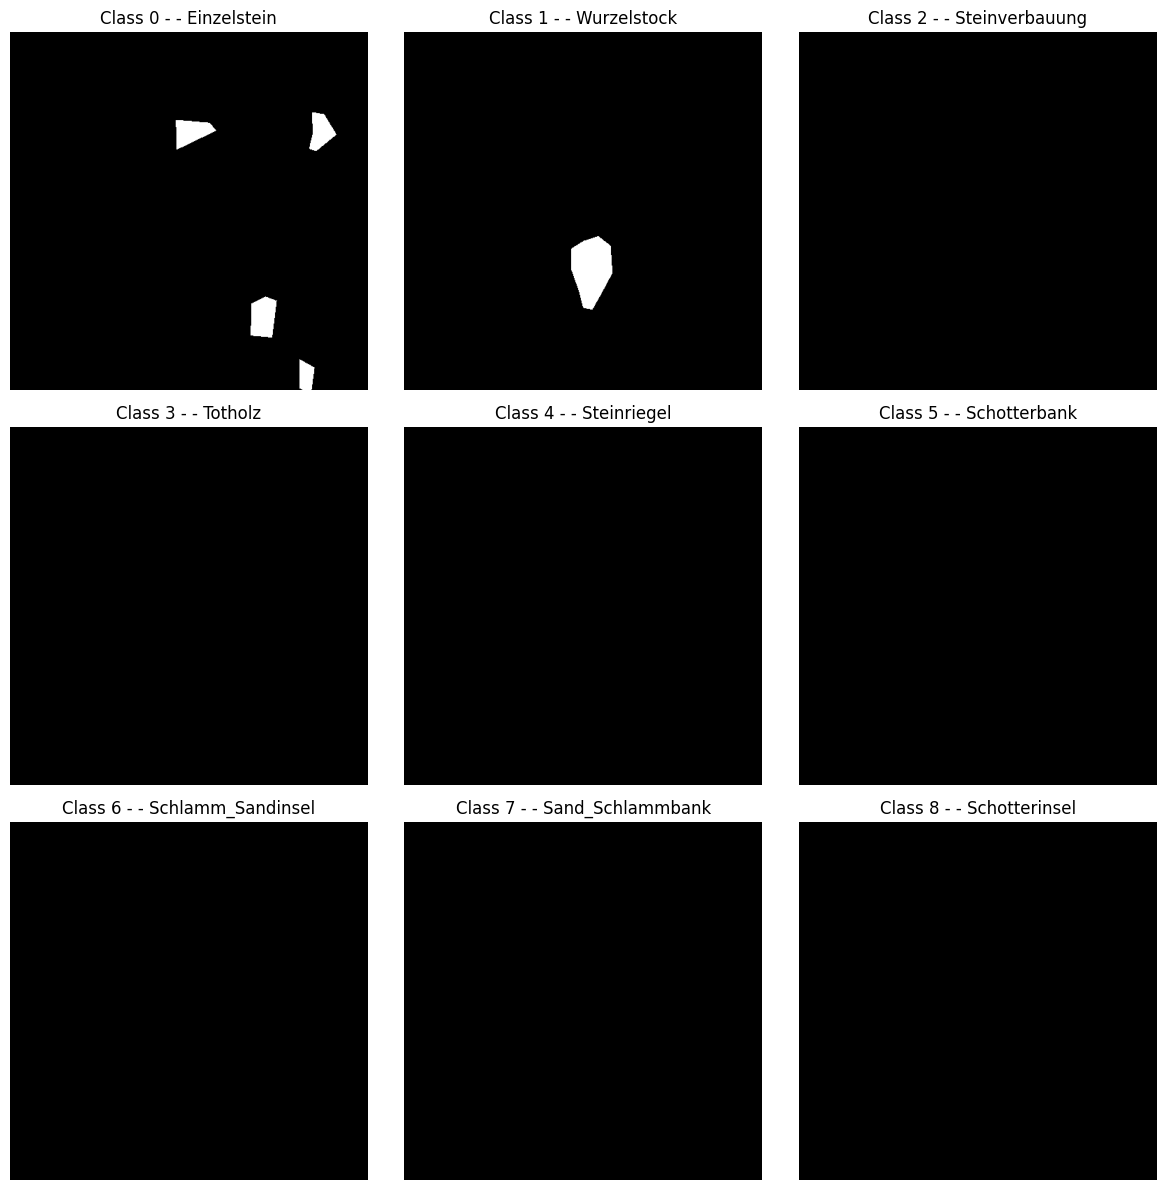

In [ ]:
try: 
    test_mask_path = output_nparr_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}_mask.npy"
    patch_mask_npy = np.load(test_mask_path, allow_pickle=True) # load NumpyArray

    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid (for 9 masks)
    axes = axes.flatten()  # easier to iterate through

    for i in range(patch_mask_npy.shape[0]):  # iterate through the 9 classes
        axes[i].imshow(patch_mask_npy[i], cmap="gray")
        axes[i].set_title(f"Class {i} - - {reversed_label_codes[i + 1]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

except:
    print("There aren't any labels in this patch!")



4. Plot mask together with corresponding patch

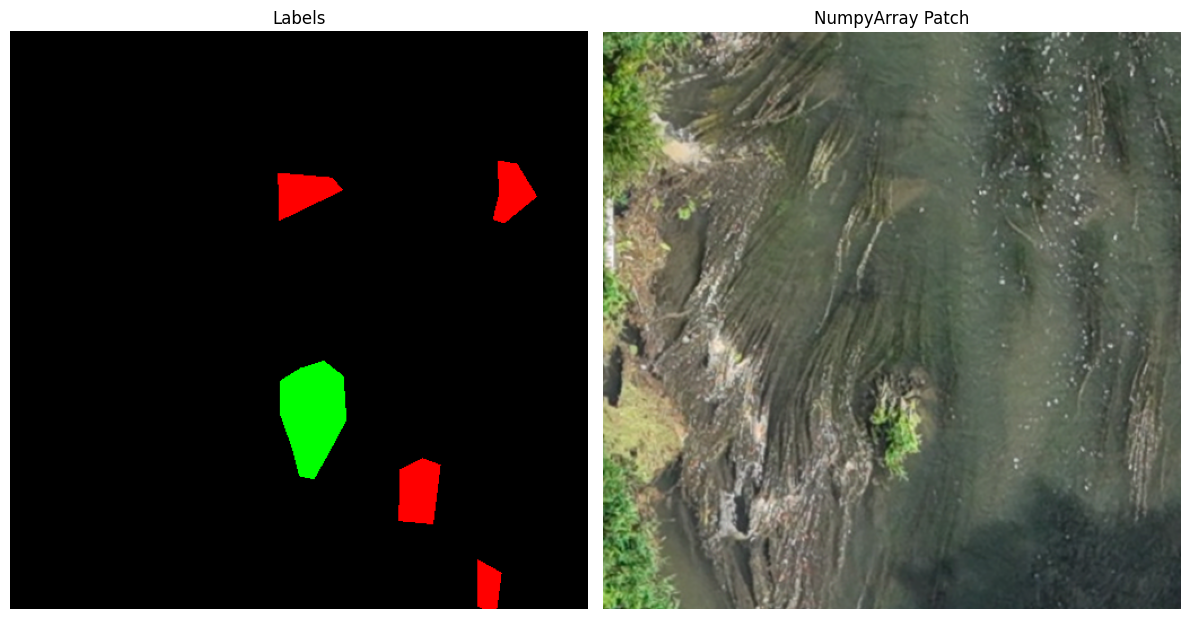

In [137]:
try:
    test_mask_path = output_nparr_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}_mask.npy"
    patch_mask_npy = np.load(test_mask_path, allow_pickle=True) # load NumpyArray mask
    
    # print(patch_mask_npy.shape): (9, 512, 512)
    combined_mask = np.zeros((patch_mask_npy.shape[1], patch_mask_npy.shape[2], 3), dtype=np.uint8) # combine the layers of the mask into one!

    class_colors = [
        [255, 0, 0],    # Klasse 1: Rot
        [0, 255, 0],    # Klasse 2: Grün
        [0, 0, 255],    # Klasse 3: Blau
        [255, 255, 0],  # Klasse 4: Gelb
        [255, 0, 255],  # Klasse 5: Magenta
        [0, 255, 255],  # Klasse 6: Cyan
        [128, 0, 0],    # Klasse 7: Dunkelrot
        [0, 128, 0],    # Klasse 8: Dunkelgrün
        [0, 0, 128],    # Klasse 9: Dunkelblau
    ]

    for i in range(patch_mask_npy.shape[0]):  # iterate through the 9 classes
        class_value = i + 1 
        color_mask = np.zeros((patch_mask_npy.shape[1], patch_mask_npy.shape[2], 3), dtype=np.uint8)
        color_mask[patch_mask_npy[i] == 1] = class_colors[i] 
        combined_mask += color_mask 

    fig, axes = plt.subplots(1, 2, figsize=(12, 12))  
   
    axes[0].imshow(combined_mask)
    axes[0].set_title(f"Labels")
    axes[0].axis("off")

    axes[1].imshow(test_image_data_npy.transpose(1, 2, 0))  # transpose for RGB depiction
    axes[1].set_title("NumpyArray Patch")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

except:
    print("There aren't any labels in this patch!")
    


An error occurred: boolean index did not match indexed array along axis 0; size of axis is 3 but size of corresponding boolean axis is 512


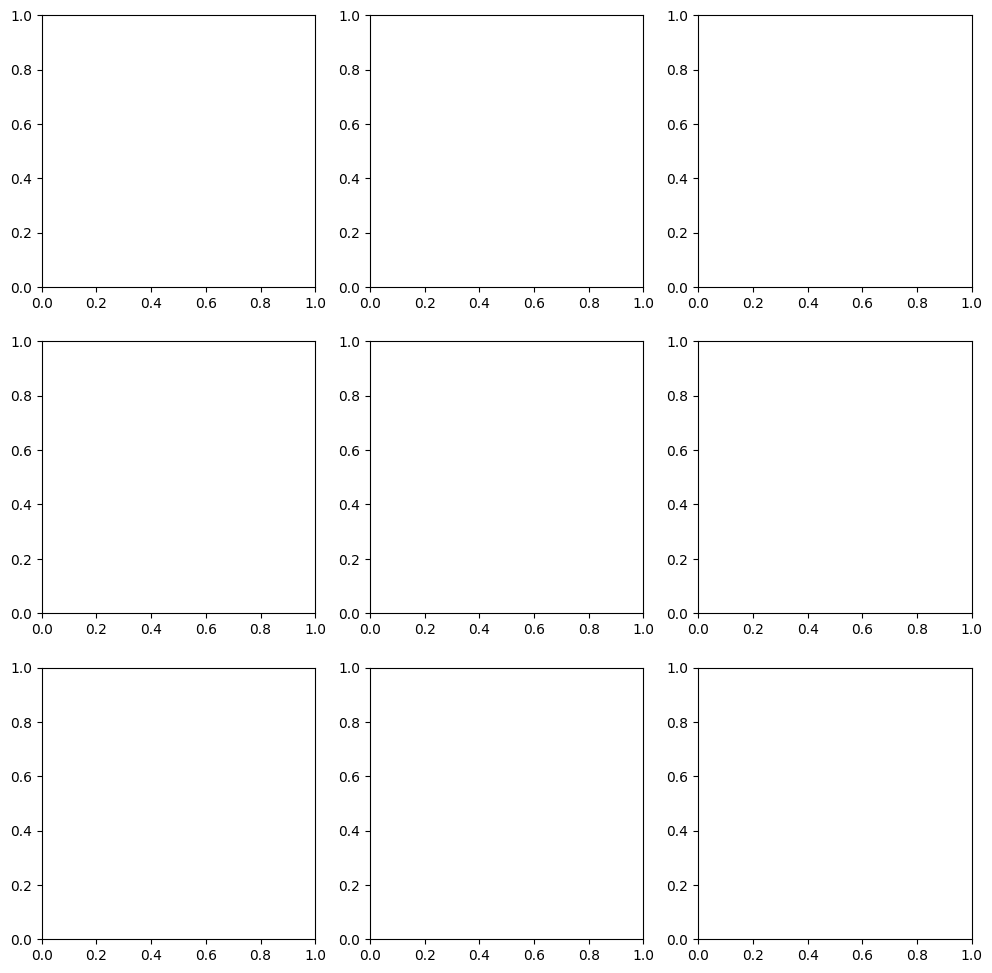

In [ ]:
# try:
#     if patch_mask_npy is not None:
#         # Create an empty image to hold the masked areas
#         masked_image = np.zeros_like(test_image_data_npy)  # Empty array with the same shape as the patch image
        
#         # Create a 3x3 grid to display 9 masks
#         fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid for 9 masks
#         axes = axes.flatten()  # Easier to iterate through
        
#         for n in range(patch_mask_npy.shape[0]):  # Iterate through all 9 classes
#             # Create an empty mask for the current class
#             color_mask = np.zeros_like(test_image_data_npy)  # Mask for each class
            
#             # Apply the mask: Set image data only where the mask is present
#             color_mask[patch_mask_npy[n] > 0] = test_image_data_npy[patch_mask_npy[n] > 0]

#             # Combine the masks for the output
#             masked_image = np.maximum(masked_image, color_mask)  # Apply each mask to the image

#             # Display the masked image for each class
#             axes[n].imshow(masked_image.transpose(1, 2, 0))  # Transpose for RGB representation
#             axes[n].set_title(f"Class {n + 1} - {reversed_label_codes[n + 1]}")
#             axes[n].axis("off")

#         # Optimize layout
#         plt.tight_layout()
#         plt.show()

#     else:
#         print("There aren't any labels in this patch!")

# except Exception as e:
#     print(f"An error occurred: {e}")


5. Plot mask from the GeoTIFF

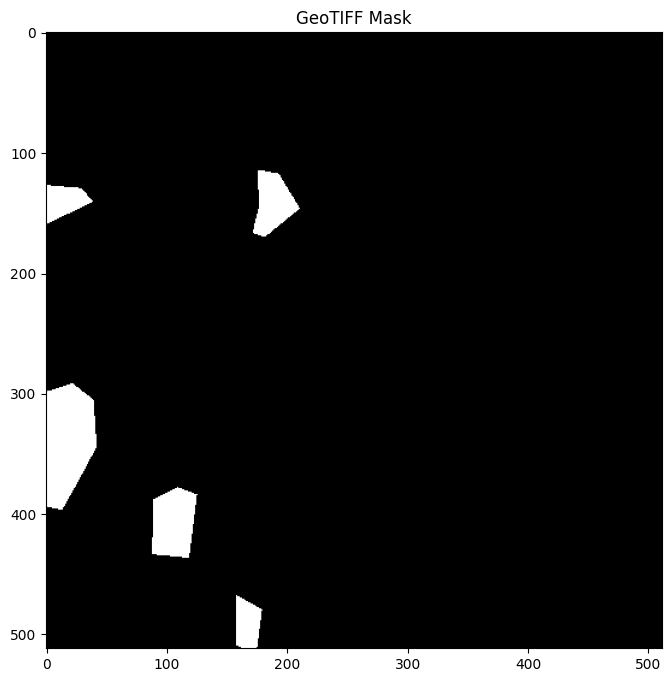

In [19]:
# load test GeoTIFF patch and plot the mask data (fourth band)
with rasterio.open(test_gtif) as src:
    # Check how many bands are available
    num_bands = src.count

    if num_bands >= 4:  # Check if a fourth band (mask) exists
        patch_mask_data = src.read(4)  # Read the fourth band
        
        # Plot the mask
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(patch_mask_data, cmap="gray")  # Display the mask in grayscale
        ax.set_title("GeoTIFF Mask")
        plt.show()

    else:
        print("There aren't any labels in this patch!")

6. Load and show meta data (JSON)

In [20]:
test_metadata = output_json_dir + f"/{gtif_name}_metadata.json"

# open and read meta data
with open(test_metadata) as json_file:
    metadata = json.load(json_file)

# show meta data of first two patches
print("meta data of first two patches:")
for patch in metadata[:2]:
    print(f"Patch ID: {patch['patch_id']}")
    print(f"Bounds: {patch['bounds']}")
    print(f"Transform: {patch['transform']}")
    print("-" * 30)

# show meta data to patch TEST_PATCH_ID
print("meta data of selected patch:")
print(metadata[TEST_PATCH_ID]['patch_id'])
print(metadata[TEST_PATCH_ID])



meta data of first two patches:
Patch ID: 0
Bounds: [11.265079558766594, 48.75042967464041, 11.265246644334594, 48.750540169360406]
Transform: [11.265079558766594, 3.2633900000001453e-07, 0.0, 48.750540169360406, 0.0, -2.1580999999988398e-07]
------------------------------
Patch ID: 1
Bounds: [11.265163101550593, 48.75042967464041, 11.265330187118593, 48.750540169360406]
Transform: [11.265163101550593, 3.2633900000001453e-07, 0.0, 48.750540169360406, 0.0, -2.1580999999988398e-07]
------------------------------
meta data of selected patch:
185
{'patch_id': 185, 'bounds': [11.265914986606594, 48.7499876957604, 11.266082072174594, 48.75009819048041], 'transform': [11.265914986606594, 3.2633900000001453e-07, 0.0, 48.75009819048041, 0.0, -2.1580999999988398e-07]}


### 2.5 OPTIONAL: Check the orthophoto

In [21]:
# check the whole orthophoto
nparr_data

NameError: name 'nparr_data' is not defined

In [22]:
# check meta data
gtif_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 17270,
 'height': 25023,
 'count': 4,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(3.2633900000001453e-07, 0.0, 11.263241617518593,
        0.0, -2.1580999999988398e-07, 48.750540169360406)}

In [255]:
# check geometrical properties
gtif_crs, gtif_bounds, gtif_height, gtif_width

(CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 BoundingBox(left=11.263241617518593, bottom=48.74513995573041, right=11.268877492048594, top=48.750540169360406),
 25023,
 17270)